1) Start Spark session

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName("desafio_IGTI").getOrCreate() #cria a seção caso não exista ou obtém a já criada

In [0]:
%fs ls /FileStore/tables   

path,name,size,modificationTime
dbfs:/FileStore/tables/Mall_Customers.csv,Mall_Customers.csv,4286,1672929952000
dbfs:/FileStore/tables/mall_customers/,mall_customers/,0,0
dbfs:/FileStore/tables/mall_customers.csv,mall_customers.csv,4286,1672929982000
dbfs:/FileStore/tables/stroke_data.csv,stroke_data.csv,316971,1675366710000


In [0]:
dir_dataset = "/FileStore/tables/stroke_data.csv"  # Dir with the dataset to be used

In [0]:
dataset = spark.read.format("csv").options(header="true", inferschema="true").load(dir_dataset)  # Reads the dataset

In [0]:
dataset.printSchema() # Show dataset schema

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [0]:
print(f"DataFrame Rows count: { dataset.count() }")
print(f"DataFrame Columns count: { len(dataset.columns) }")

DataFrame Rows count: 5110
DataFrame Columns count: 12


In [0]:
from collections import Counter

# Counts number of columns by type
print(Counter((x[1] for x in dataset.dtypes)))

Counter({'string': 6, 'int': 4, 'double': 2})


In [0]:
dataset.show() # Shows dataset preview

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

2. Dataset Analysis

In [0]:
# Avg age in the dataset
dataset.agg({ "age": "avg" }).show()

+------------------+
|          avg(age)|
+------------------+
|43.226614481409015|
+------------------+



In [0]:
from pyspark.sql.functions import percentile_approx

# Median glucose level
dataset.agg(percentile_approx("avg_glucose_level", 0.5).alias("Median Glucose Level")).show()

+--------------------+
|Median Glucose Level|
+--------------------+
|               91.85|
+--------------------+



In [0]:
# Groups by gender
dataset.groupby("gender", "stroke").count().sort("stroke").show()

+------+------+-----+
|gender|stroke|count|
+------+------+-----+
| Other|     0|    1|
|Female|     0| 2853|
|  Male|     0| 2007|
|  Male|     1|  108|
|Female|     1|  141|
+------+------+-----+



In [0]:
# Is dataset balanced
dataset.groupby("stroke").count().sort("count").show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



In [0]:
from pyspark.sql.functions import asc

# See types of residences
dataset.groupBy("Residence_type").agg({'Residence_type': 'count'}).sort(asc("count(Residence_type)")).show()

+--------------+---------------------+
|Residence_type|count(Residence_type)|
+--------------+---------------------+
|         Rural|                 2514|
|         Urban|                 2596|
+--------------+---------------------+



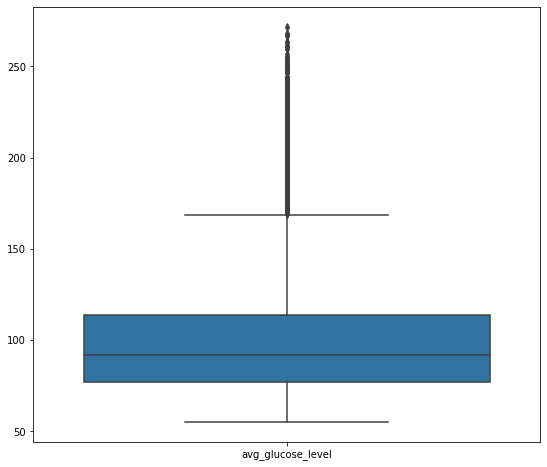

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gets distribution for glucose level
x = dataset.select("avg_glucose_level").toPandas()
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

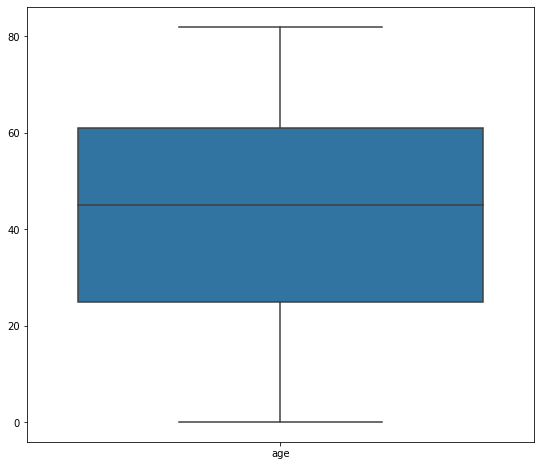

In [0]:
# Gets distribution for age
x = dataset.select("age").toPandas()
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

In [0]:
# See types of work
dataset.groupBy("work_type").agg({ "work_type": "count" }).sort(asc("count(work_type)")).show()

+-------------+----------------+
|    work_type|count(work_type)|
+-------------+----------------+
| Never_worked|              22|
|     Govt_job|             657|
|     children|             687|
|Self-employed|             819|
|      Private|            2925|
+-------------+----------------+



3) Model training

In [0]:
# Filter values with unknow values
dataset_filtered = dataset.filter((dataset['bmi'] != 'N/A') & (dataset['smoking_status'] > 'Unknown'))

In [0]:
# Applies categorical values transformation
from pyspark.ml.feature import VectorAssembler,OneHotEncoder, StringIndexer

In [0]:
# Defines the transformation for the gender variable
stringIndexer_gender = StringIndexer(inputCol="gender", outputCol="gender_encoded")  #l Label encoding
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec") # One-hot encoding

In [0]:
# Defines the transformation for the ever_married variable
stringIndexer_married = StringIndexer(inputCol="ever_married", outputCol="ever_married_encoded") # Label encoding
encoder_married = OneHotEncoder(dropLast=False, inputCol="ever_married_encoded", outputCol="marriedVec") # One-hot encoding

In [0]:
# Defines the transformation for the work_type variable
stringIndexer_work = StringIndexer(inputCol="work_type", outputCol="work_type_encoded")  # Label encoding
encoder_work = OneHotEncoder(dropLast=False, inputCol="work_type_encoded", outputCol="workVec") # One-hot encoding

In [0]:
# Defines the transformation for the Residence_type variable
stringIndexer_residence = StringIndexer(inputCol="Residence_type", outputCol="Residence_type_encoded")  # Label encoding
encoder_residence = OneHotEncoder(dropLast=False, inputCol="Residence_type_encoded", outputCol="residenceVec") # One-hot encoding

In [0]:
# Defines the transformation for the smoking_status variable
stringIndexer_smoking = StringIndexer(inputCol="smoking_status", outputCol="smoking_status_encoded")  # Label encoding
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec") # One-hot encoding

In [0]:
# Defines the input vector
input_cols = ['age','hypertension', 'heart_disease','avg_glucose_level','genderVec','marriedVec','workVec','residenceVec','smokingVec']
input_vector = VectorAssembler(inputCols=input_cols, outputCol='features')

In [0]:
# Defines the pipeline sequence
sequence = [stringIndexer_gender, stringIndexer_married,stringIndexer_work,stringIndexer_residence,stringIndexer_smoking,
             encoder_gender,encoder_married,encoder_work,encoder_residence,encoder_smoking,input_vector]

In [0]:
from pyspark.ml import Pipeline

# Builds the pipeline
pipeline = Pipeline(stages=sequence)
pipelineModel = pipeline.fit(dataset_filtered)
model = pipelineModel.transform(dataset_filtered)

In [0]:
# Shows a preview of the input data
model.select('age','gender','genderVec','ever_married','marriedVec','features').show()

+----+------+-------------+------------+-------------+--------------------+
| age|gender|    genderVec|ever_married|   marriedVec|            features|
+----+------+-------------+------------+-------------+--------------------+
|67.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|80.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|49.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,10...|
|81.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,5,7,9,14...|
|74.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,2,3,5,7,...|
|69.0|Female|(3,[0],[1.0])|          No|(2,[1],[1.0])|(19,[0,3,4,8,9,14...|
|81.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,9,...|
|61.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,4,7,11...|
|54.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female

In [0]:
# Splits dataset into training and testing
train_data, test_data = model.randomSplit([.8,.2],seed=1)

In [0]:
# Uses logistic regressions to traing
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="stroke", featuresCol="features", maxIter=100, regParam=0.3)
linearModel = lr.fit(train_data)

In [0]:
# Predicts
predictions = linearModel.transform(test_data)

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluates
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
acuracia_regressao = acc_evaluator.evaluate(previsao_regressao)
print('Regressão Logística: {0:2.2f}%'.format(acuracia_regressao*100))

Regressão Logística: 94.31%
